# Estimating prediction confidence through dropout 

- toc:true
- badges: true
- comments: true
- author: Pushkar G. Ghanekar
- categories: [python, pytorch, machine-learning]

* Adapted from Deep Learning online course notes from NYU. [Note link](https://atcold.github.io/pytorch-Deep-Learning/en/week14/14-3/)
* [Paper about using Dropout as a Bayesian Approximation](https://arxiv.org/pdf/1506.02142.pdf)

Another notebook which uses PyTorch dropout: [Link](https://xuwd11.github.io/Dropout_Tutorial_in_PyTorch/)

* [New paper on evidential deep learning for guided molecular property prediction](https://arxiv.org/abs/1910.02600)

In addition to predicting a value from a model it is also important to know the confidence in that prediction. Dropout is one way of estimating this. After multiple rounds of predictions, the mean and standard deviation in the prediction can be viewed as the prediction value and the corresponding confidence in the prediction. It is important to note that this is different from the error in the prediction. The model may have error in the prediction but could be precise in that value. It is similar to the idea of accuracy vs precision. 

When done with dropout -- the weights in the NN are scale by $\frac{1}{1-r}$ to account for dropping of the weights 

Type of uncertainties: 
[Aleaotric and Epistemic uncertainty](https://arxiv.org/abs/1703.04977)

* Aleatoric uncertainty captures noise inherent in the observations
* Epistemic uncertainty accounts for uncertainty in the model

The ideal way to measure epistemic uncertainty is to train many different models, each time using a different random seed and possibly varying hyperparameters. Then use all of them for each input and see how much the predictions vary. This is very expensive to do, since it involves repeating the whole training process many times. Fortunately, we can approximate the same effect in a less expensive way: by using dropout -- effectively training a huge ensemble of different models all at once. Each training sample is evaluated with a different dropout mask, corresponding to a different random subset of the connections in the full model. Usually we only perform dropout during training and use a single averaged mask for prediction. But instead, let's use dropout for prediction too. We can compute the output for lots of different dropout masks, then see how much the predictions vary. This turns out to give a reasonable estimate of the **epistemic uncertainty in the outputs**

In [1]:
import torch 
from torch import nn, optim
import numpy as np 

In [2]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

%config InlineBackend.figure_format = 'retina'
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

plot_params = {
'font.size' : 22,
'axes.titlesize' : 24,
'axes.labelsize' : 20,
'axes.labelweight' : 'bold',
'lines.linewidth' : 3,
'lines.markersize' : 10,
'xtick.labelsize' : 16,
'ytick.labelsize' : 16,
}
 
plt.rcParams.update(plot_params)

In [3]:
# Check if GPU present: 
print(torch.cuda.device_count())
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

0
cpu


/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [4]:
# Training set
m = 40
x = (torch.rand(m) - 0.5) * 20 #Returns a tensor filled with random numbers from a uniform distribution on the interval [0, 1)
y = x * torch.sin(x) 
#y = 2 * torch.exp( - torch.sin( (x/2)**2 ))

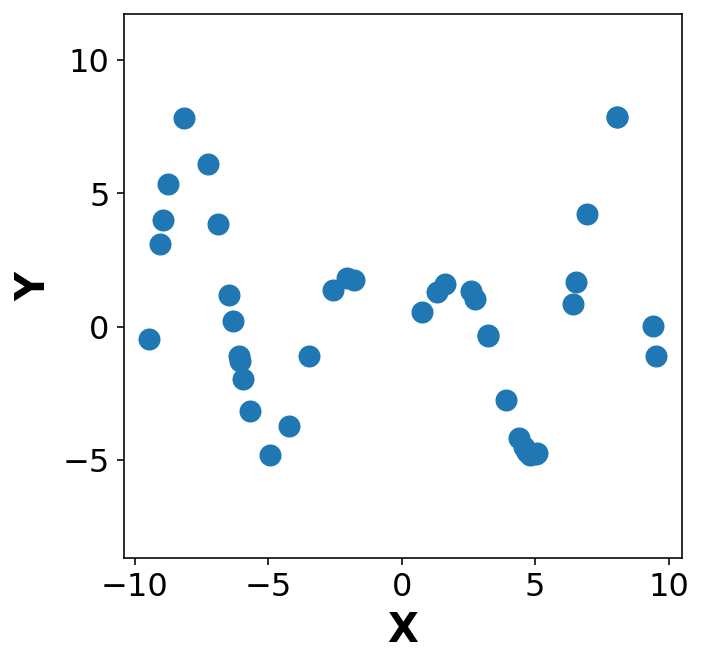

In [5]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.plot(x.numpy(), y.numpy(), 'o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.axis('equal');

In [6]:
# Define a simple NN 
class MLP(nn.Module):
    def __init__(self, hidden_layers=[20, 20], droprate=0.2, activation='relu'):
        super(MLP, self).__init__()
        
        self.model = nn.Sequential()
        self.model.add_module('input', nn.Linear(1, hidden_layers[0]))
        
        if activation == 'relu':
            self.model.add_module('relu0', nn.ReLU())
        
        elif activation == 'tanh':
            self.model.add_module('tanh0', nn.Tanh())
            
        for i in range(len(hidden_layers)-1):
            self.model.add_module('dropout'+str(i+1), nn.Dropout(p=droprate))
            self.model.add_module('hidden'+str(i+1), nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            
            if activation == 'relu':
                self.model.add_module('relu'+str(i+1), nn.ReLU())
                
            elif activation == 'tanh':
                self.model.add_module('tanh'+str(i+1), nn.Tanh())
                
        self.model.add_module('dropout'+str(i+2), nn.Dropout(p=droprate))
        self.model.add_module('final', nn.Linear(hidden_layers[i+1], 1))
        
    def forward(self, x):
        return self.model(x)

In [7]:
# Define the model 
net = MLP(hidden_layers=[200, 100, 80], droprate=0.1).to(device) #Move model to the GPU 
print(net)

MLP(
  (model): Sequential(
    (input): Linear(in_features=1, out_features=200, bias=True)
    (relu0): ReLU()
    (dropout1): Dropout(p=0.1, inplace=False)
    (hidden1): Linear(in_features=200, out_features=100, bias=True)
    (relu1): ReLU()
    (dropout2): Dropout(p=0.1, inplace=False)
    (hidden2): Linear(in_features=100, out_features=80, bias=True)
    (relu2): ReLU()
    (dropout3): Dropout(p=0.1, inplace=False)
    (final): Linear(in_features=80, out_features=1, bias=True)
  )
)


In [8]:
# Objective and optimizer 
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay=0.00001)

In [9]:
x_dev = x.view(-1, 1).to(device)

In [10]:
# Training loop 
for epoch in range(6000):
    x_dev = x.view(-1, 1).to(device)
    y_dev = y.view(-1, 1).to(device)
    y_hat = net(x_dev)
    loss = criterion(y_hat, y_dev)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print('Epoch[{}] - Loss:{}'.format(epoch, loss.item()))

Epoch[0] - Loss:12.986040115356445
Epoch[500] - Loss:2.8153011798858643
Epoch[1000] - Loss:0.8509715795516968
Epoch[1500] - Loss:1.6130517721176147
Epoch[2000] - Loss:1.1730057001113892
Epoch[2500] - Loss:0.33764439821243286
Epoch[3000] - Loss:0.3624637722969055
Epoch[3500] - Loss:0.6254412531852722
Epoch[4000] - Loss:0.5281579494476318
Epoch[4500] - Loss:0.43325310945510864
Epoch[5000] - Loss:0.8039093017578125
Epoch[5500] - Loss:0.4330228865146637


Define a separate continuous vector `XX`

In [11]:
XX = torch.linspace(-11, 11, 1000)

In [12]:
def predict_reg(model, X, T=10):
    '''
    Running the model in training mode. 
    model = torch.model: NN implemented in pytorch
    X = torch.tensor: Input vector 
    T = int: number of samples run 
    
    OUT:
    Y_hat = sample of predictions from NN model
    Y_eval = average prediction value from NN model
    '''
    
    model = model.train()
    Y_hat = list()
    
    with torch.no_grad():
        for t in range(T):
            X_out = model(X.view(-1,1).to(device))
            Y_hat.append(X_out.cpu().squeeze())
            
    Y_hat = torch.stack(Y_hat)
    
    model = model.eval()
    with torch.no_grad():
        X_out = model(X.view(-1,1).to(device))
        Y_eval = X_out.cpu().squeeze()

    return Y_hat, Y_eval

In [13]:
%%time 
y_hat, y_eval = predict_reg(net, XX, T=1000)
mean_y_hat = y_hat.mean(axis=0)
std_y_hat = y_hat.std(axis=0)

CPU times: user 11.6 s, sys: 47.7 ms, total: 11.6 s
Wall time: 11.7 s


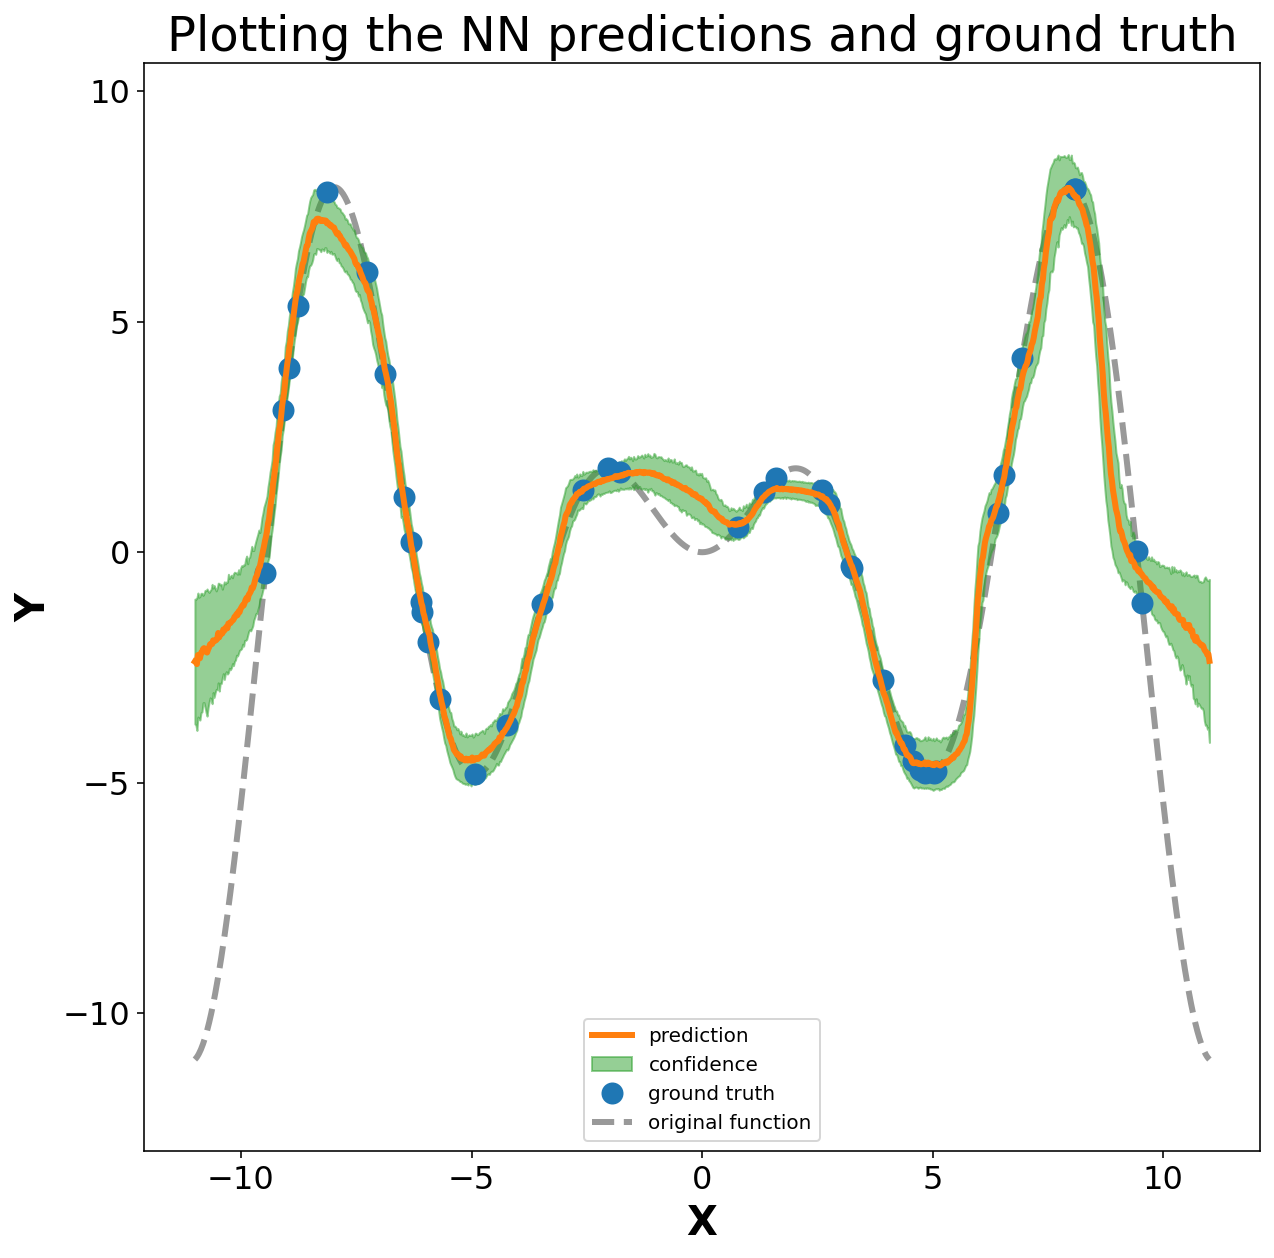

In [14]:
# Visualise mean and mean ± std -> confidence range
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.plot(XX.numpy(), mean_y_hat.numpy(), 'C1', label='prediction')
ax.fill_between(XX.numpy(), (mean_y_hat + std_y_hat).numpy(), (mean_y_hat - std_y_hat).numpy(), alpha=0.5, color='C2', label='confidence')
ax.plot(x.numpy(), y.numpy(), 'oC0', zorder=1, label='ground truth')
ax.plot(XX.numpy(), (XX * torch.sin(XX)).numpy(), 'k--', alpha=0.4, zorder=0, label='original function')
ax.set_title('Plotting the NN predictions and ground truth')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.axis('equal')
plt.legend(loc='best', fontsize=10)

The plot above is the combination of `ground truth` points (blue), `original function` (grey) and the `predicted function` (orange) with corresponding confidence interval at each ML-prediction (green). It is seen that the ML model does well for the region of X in the range of original points. Another interesting observation is the uncertainity of the model prediction, which is seen to increase in the space where training points dont exist e.g. X=(5,10) and X > 10 or X < -10. This shows that the model is highly uncertain outside the domain of training data (extrapolation) but does a decent job within the range of training data (interpolation). 